# Transformers

**Name - Mitul Srivastava**

**ID - C00313606**

## **LOG** : Introduction to dataset
### **DATASET** : Daily minimum temperatures
### **DETAIL** : This data set contains information about daily minimum temperatures from 1981 to 1990..
### **AIM** : To train and fine tune Transformer to correctly forecast temperature.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('1_Daily_minimum_temps.csv', index_col='Date', parse_dates=True)
data.head()

<ipython-input-2-ddf9c41eeed1>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('1_Daily_minimum_temps.csv', index_col='Date', parse_dates=True)


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
data['Temp'] = pd.to_numeric(data['Temp'], errors='coerce')
data.dropna(inplace=True)

In [4]:
scaler = MinMaxScaler()
data['Temp'] = scaler.fit_transform(data['Temp'].values.reshape(-1, 1))

**LOG:** Preparing data for time series forecasting

In [5]:
def prepare_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data['Temp'].iloc[i:(i + seq_length)].values)
        y.append(data['Temp'].iloc[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Length of input sequence
X, y = prepare_data(data, seq_length)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**LOG:** Reshaping data for Transformer model

In [7]:
X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

**LOG:** Transformer Model Definition

In [8]:
def transformer_model(seq_length, num_features, d_model, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.1):
    inputs = tf.keras.layers.Input(shape=(seq_length, num_features))

    # Embedding layer
    embedding = tf.keras.layers.Dense(d_model)(inputs)
    pos_encoding = positional_encoding(seq_length, d_model)
    x = embedding + pos_encoding

     # Transformer blocks
    for _ in range(num_transformer_blocks):
        attention_output = transformer_encoder(x, d_model, num_heads, ff_dim, dropout_rate)
        x = tf.keras.layers.Add()([x, attention_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Output layer
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1)(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [9]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
def transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout_rate=0.1):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention)
    out = tf.keras.layers.Add()([inputs, attention])

    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(d_model),
    ])
    ffn_output = ffn(out)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    ffn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn_output)
    return tf.keras.layers.Add()([out, ffn_output])

**LOG:** Defining model parameters

In [11]:
num_features = 1
d_model = 32
num_heads = 2
ff_dim = 32
num_transformer_blocks = 2
dropout_rate = 0.1

**LOG:**  Creating the Transformer model

In [12]:
model = transformer_model(seq_length, num_features, d_model, num_heads, ff_dim, num_transformer_blocks, dropout_rate)


**LOG:** Compiling the model

In [13]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

**LOG:** # Displaying model summary

In [14]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30, 32)         │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 30, 32)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 32)         │          8,416 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 32)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 30, 32)         │             64 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 32)         │              0 │ add[0][0],             │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 30, 32)         │          2,112 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 30, 32)         │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 32)         │             64 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 30, 32)         │              0 │ add_1[0][0],           │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 30, 32)         │              0 │ add[0][0], add_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 30, 32)         │             64 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 30, 32)         │          8,416 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 30, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 30, 32)         │             64 │ dropout_4[0][0]        │
│ (LayerNormalization) 

 Total params: 21,537 (84.13 KB)

 Trainable params: 21,537 (84.13 KB)

 Non-trainable params: 0 (0.00 B)

LOG: Training the model

In [15]:

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.2856 - val_loss: 0.0150
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0238 - val_loss: 0.0137
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0200 - val_loss: 0.0132
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0186 - val_loss: 0.0164
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0176 - val_loss: 0.0158
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0159 - val_loss: 0.0131
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0167 - val_loss: 0.0144
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0151 - val_loss: 0.0131
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0152 - val_loss: 0.0120
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0117 - val_loss: 0.0129
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.

LOG: Ploting training history

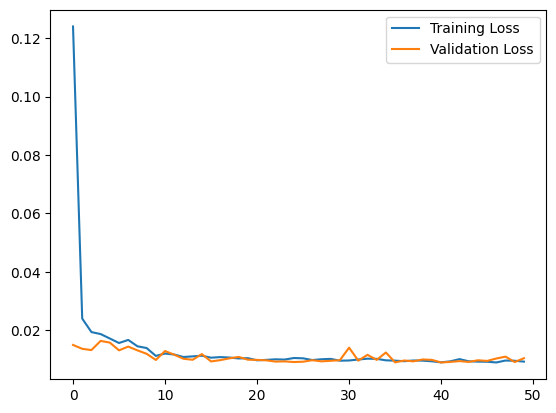

In [16]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

LOG: Evaluating the model

In [17]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')

Test Loss: 0.0104


**LOG:** Making predictions

In [18]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_original, predictions)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [28]:
print(f'MAE: {mae:.4f}')

MAE: 2.1203


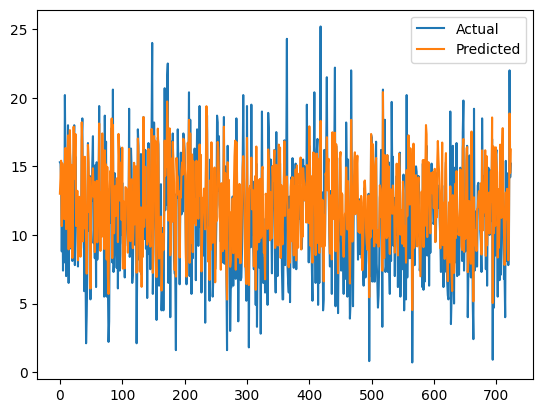

In [19]:
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

LOG: Fine tuning the model by doubling the number of transformer blocks and the feedforward dimensions.


In [20]:
d_model_tuned = 64
num_heads_tuned = 4
ff_dim_tuned = 64
num_transformer_blocks_tuned = 4
dropout_rate_tuned = 0.2

In [21]:
tuned_model = transformer_model(seq_length, num_features, d_model_tuned, num_heads_tuned, ff_dim_tuned, num_transformer_blocks_tuned, dropout_rate_tuned)
tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [22]:
tuned_history = tuned_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 2.5798 - val_loss: 0.0329
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 0.1371 - val_loss: 0.0277
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 0.0595 - val_loss: 0.0242
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 0.0392 - val_loss: 0.0328
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 0.0312 - val_loss: 0.0223
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - loss: 0.0259 - val_loss: 0.0263
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0229 - val_loss: 0.0186
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 0.0230 - val_loss: 0.0160
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 0.0179 - val_loss: 0.0149
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.0146 - val_loss: 0.0106
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - loss: 0.0130 - val_loss: 0.0104
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20

**LOG:** The test loss decreased from 0.0117 to 0.0100

In [23]:
tuned_loss = tuned_model.evaluate(X_test, y_test, verbose=0)
print(f'Tuned Test Loss: {tuned_loss:.4f}')

Tuned Test Loss: 0.0100


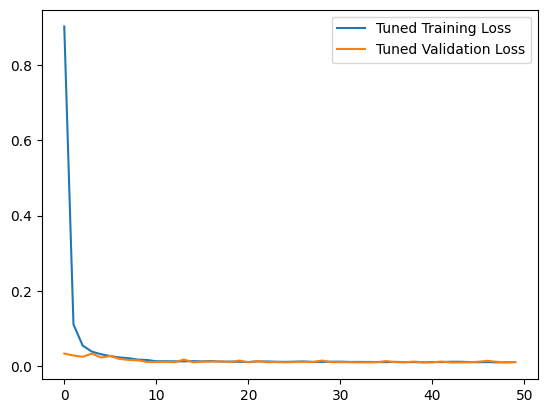

In [24]:
plt.plot(tuned_history.history['loss'], label='Tuned Training Loss')
plt.plot(tuned_history.history['val_loss'], label='Tuned Validation Loss')
plt.legend()
plt.show()


In [25]:
tuned_predictions = tuned_model.predict(X_test)
tuned_predictions = scaler.inverse_transform(tuned_predictions)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


LOG: The mean absolute error of the tuned model for predictions reduced from 2.1203 of the original to 2.0663.

In [29]:
mae_tuned = mean_absolute_error(y_test_original, tuned_predictions)
print(f'Tuned MAE: {mae_tuned:.4f}')

Tuned MAE: 2.0663


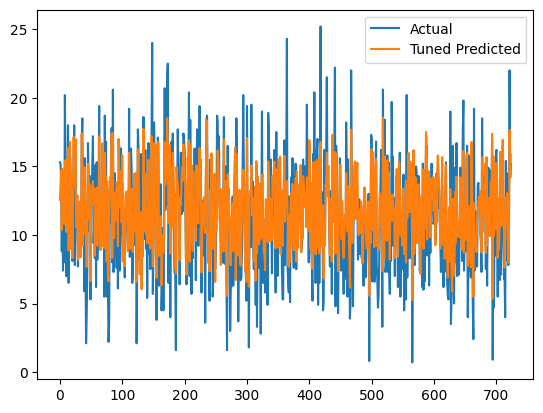

In [26]:
plt.plot(y_test_original, label='Actual')
plt.plot(tuned_predictions, label='Tuned Predicted')
plt.legend()
plt.show()

### **REFERENCES** :
### https://chatgpt.com/
### https://www.perplexity.ai/
### https://www.kaggle.com/datasets/suprematism/daily-minimum-temperatures